In [33]:
import os, sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
mkl.set_num_threads(10)

import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our |plotting is done with plt
from src import utils # this is our own library of functions
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
#sys.path.insert(0, '/home/mano/Documents/Profesional Projects/Suite2p/suite2p/') #linux import
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
exp_db

[{'mname': 'TX80', 'datexp': '2022_06_17', 'blk': '1'}]

In [129]:
iexp       = 0
dual_plane = 1
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat = utils.load_neurons(exp_db[iexp], dual_plane=True,baseline=True)

(20,)
plane 0,  neurons: 1098
plane 1,  neurons: 4180
plane 2,  neurons: 5125
plane 3,  neurons: 4101
plane 4,  neurons: 2319
plane 5,  neurons: 2326
plane 6,  neurons: 5271
plane 7,  neurons: 4153
plane 8,  neurons: 4344
plane 9,  neurons: 2990
plane 10,  neurons: 684
plane 11,  neurons: 2519
plane 12,  neurons: 2965
plane 13,  neurons: 2655
plane 14,  neurons: 1535
plane 15,  neurons: 1882
plane 16,  neurons: 3598
plane 17,  neurons: 2869
plane 18,  neurons: 2918
plane 19,  neurons: 1649
total neurons 59181


# Plot neuron positions

Text(0, 0.5, 'Y position (um)')

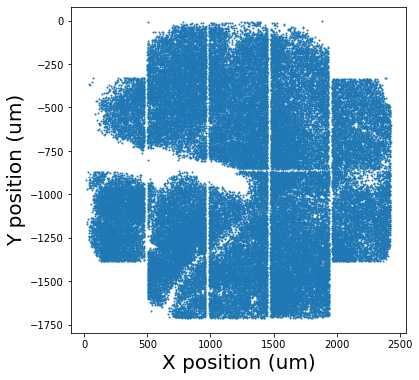

In [133]:
plt.figure(figsize=(6,6))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)

In [134]:
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)

In [253]:
avg_response, csig = utils.get_tuned_neurons(neurons_atframes, subset_stim)

In [254]:
csig.mean()


0.100595206

# Visualize tuned neurons

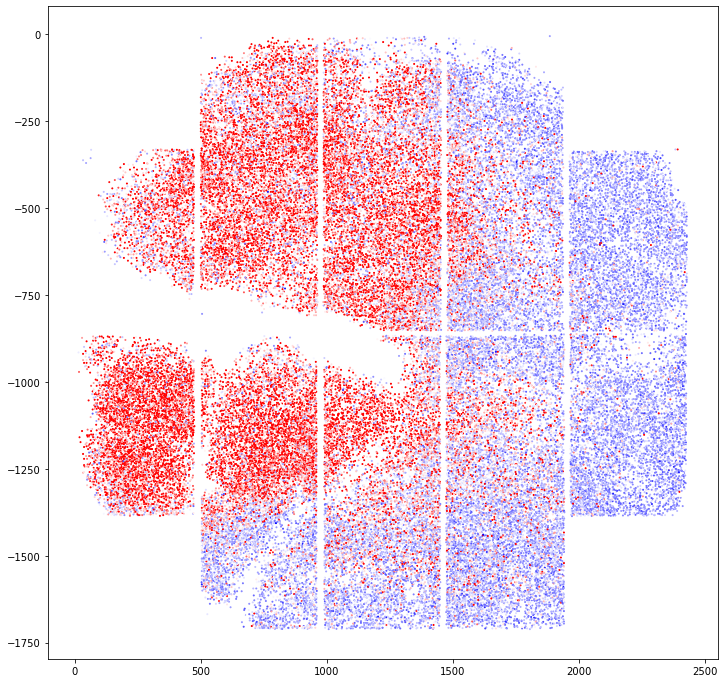

In [255]:
plt.figure(figsize=(12,12))
plt.scatter(xpos, -ypos, c = csig, cmap = 'bwr', vmax = .2, s = 1)

# Get 8x4 stimuli for the Dprime decoder
* in the session 'TX80', '2022_06_17', '1' we used a combined stimuli from nat30k and textures 8x4, this block of code retrieve only the 8x4 repeats

In [433]:
n_cat = 8
samples_per_cat = 4
total_samples = n_cat * samples_per_cat
_, nc = np.unique(subset_stim, return_counts = True)
nc = nc[:total_samples]
nreps = np.min(nc)
for exemplar in range(total_samples):
    if exemplar == 0:
        idx_4x8 = np.expand_dims(np.where(subset_stim==exemplar+1)[0][:nreps],axis=0)
    else:
        idx_4x8 = np.append(idx_4x8, np.expand_dims(np.where(subset_stim==exemplar+1)[0],axis=0),axis=0)
cats_idx = np.arange(0, total_samples, samples_per_cat)
print(f"{cats_idx.shape[0]} categories, {idx_4x8.shape[0]} exemplars, {idx_4x8.shape[1]} repeats")

8 categories, 32 exemplars, 98 repeats


In [612]:
categories_dict = {
    "0":"leaves",
    "1":"circles",
    "2":"dryland",
    "3":"rocks",
    "4":"tiles",
    "5":"squares",
    "6":"round leaves",
    "7":"paved"}

In [570]:
decoder_stimuli = np.zeros((8, neurons_atframes.shape[0], idx_4x8.shape[1]))
train_category = 0  # always even, since the even categories are the postive texture (rewarded) for each pair 
train_texture = 0 
train_idx = train_category * samples_per_cat
for exemplar in range(8):
    decoder_stimuli[exemplar] = neurons_atframes[:, idx_4x8[train_idx+exemplar]]
X_train = decoder_stimuli[:, :, ::2] #Even repeats for training
X_test = decoder_stimuli[:, :, 1::2] #Odd repeats for testing
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (8, 59181, 49)
X_test shape: (8, 59181, 49)


# Dprime calculation

In [571]:
from src.utils import DprimeDecoder
decoder = DprimeDecoder(samples_per_category=samples_per_cat, train_exemplar=train_texture, threshold=0.5)
decoder.fit(X_train)
spop = decoder.test(X_test, iplane, zstack=2)

3191 neurons above d-prime = 0.5 for train exemplar: 0 from category: leaves


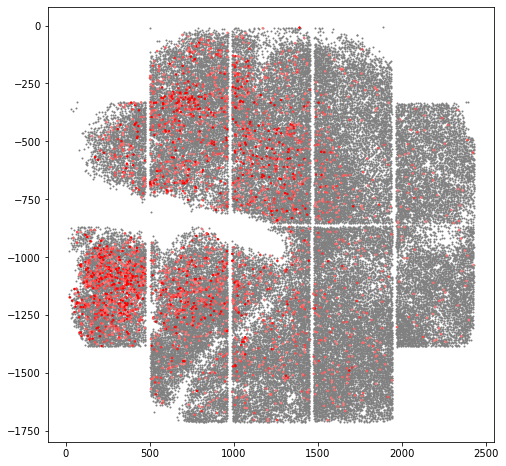

In [566]:
plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, c = 'gray', s = 1)
plt.scatter(xpos[decoder.neurons_abvtresh_], -ypos[decoder.neurons_abvtresh_], c = decoder.dprime_[0,decoder.neurons_abvtresh_], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
print(f'{decoder.neurons_abvtresh_.sum()} neurons above d-prime = 0.5 for train exemplar: {train_category} from category: {categories_dict[str(train_category)]}')

# fit a linear SVM 

In [559]:
X = spop.reshape(-1,1) #n_samples, n_features (here the feature is the mean response of the neurons selected by dprime on the train_texture)
y = np.concatenate((np.ones(196),np.zeros(196))) #n_samples = 196 * 2 , rem

In [560]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X,y)

LinearSVC(random_state=0, tol=1e-05)

mean accuracy:

In [561]:
clf.score(X,y)

0.9336734693877551

# DO all the above for each category pair, training on each exemplar pair

In [580]:
train_category = np.arange(0,8,2)  # always even, since the even categories are the postive texture (rewarded) for each pair , and it takes automatically the next category as a the negative one.
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        decoder_stimuli = np.zeros((8, neurons_atframes.shape[0], idx_4x8.shape[1]))
        train_idx = category * samples_per_cat
        for exemplar in range(8):
            decoder_stimuli[exemplar] = neurons_atframes[:, idx_4x8[train_idx+exemplar]]
        X_train = decoder_stimuli[:, :, ::2] #Even repeats for training
        X_test = decoder_stimuli[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=samples_per_cat, train_exemplar=texture, threshold=0.5)
        decoder.fit(X_train)
        spop = decoder.test(X_test, iplane, zstack=2)
        X = spop.reshape(-1,1) #n_samples, n_features (here the feature is the mean response of the neurons selected by dprime on the train_texture)
        y = np.concatenate((np.ones(196),np.zeros(196))) 
        clf = LinearSVC(random_state=0, tol=1e-5)
        clf.fit(X,y)
        acc = clf.score(X,y)
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)


 category: leaves, exemplar trained: 0, accuracy: 0.9336734693877551
 category: leaves, exemplar trained: 1, accuracy: 0.923469387755102
 category: leaves, exemplar trained: 2, accuracy: 0.8316326530612245
 category: leaves, exemplar trained: 3, accuracy: 0.9158163265306123
 category: dryland, exemplar trained: 0, accuracy: 0.701530612244898
 category: dryland, exemplar trained: 1, accuracy: 0.4744897959183674
 category: dryland, exemplar trained: 2, accuracy: 0.7474489795918368
 category: dryland, exemplar trained: 3, accuracy: 0.5867346938775511
 category: tiles, exemplar trained: 0, accuracy: 0.8698979591836735
 category: tiles, exemplar trained: 1, accuracy: 0.8086734693877551
 category: tiles, exemplar trained: 2, accuracy: 0.8622448979591837
 category: tiles, exemplar trained: 3, accuracy: 0.9005102040816326
 category: round leaves, exemplar trained: 0, accuracy: 0.8086734693877551
 category: round leaves, exemplar trained: 1, accuracy: 0.8877551020408163
 category: round leaves,

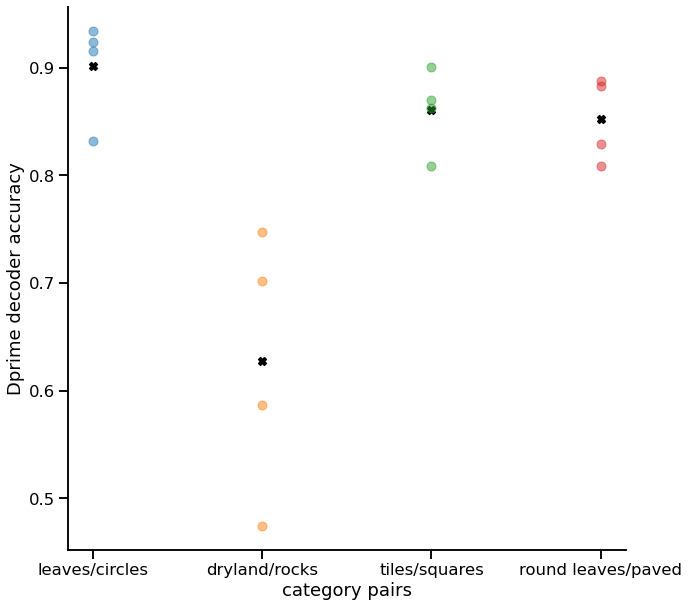

In [611]:
import seaborn as sns
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.5)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()